# Marrying Grounding DINO with Stable Diffusion for Image Editing


[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/IDEA-Research/GroundingDINO)
[![arXiv](https://img.shields.io/badge/arXiv-2303.05499-b31b1b.svg)](https://arxiv.org/abs/2303.05499) 
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/wxWDt5UiwY8)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-with-grounding-dino.ipynb)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/cMa77r3YrDk)
[![HuggingFace space](https://img.shields.io/badge/🤗-HuggingFace%20Space-cyan.svg)](https://huggingface.co/spaces/ShilongLiu/Grounding_DINO_demo)

# Install diffusers 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["CUDA_HOME"] = "/usr/local/cuda-12.3/"
# ! pip install diffusers transformers accelerate scipy safetensors

In [2]:
import argparse
from functools import partial
import cv2
import requests

from io import BytesIO
from PIL import Image
import numpy as np
from pathlib import Path


import warnings
warnings.filterwarnings("ignore")


import torch
from torchvision.ops import box_convert

from groundingdino.models import build_model
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from groundingdino.util.inference import annotate, load_image, predict
import groundingdino.datasets.transforms as T

from huggingface_hub import hf_hub_download


In [4]:
import os
import supervision as sv
from diffusers import StableDiffusionInpaintPipeline

BOX_TRESHOLD = 0.45
TEXT_TRESHOLD = 0.25


def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swint_ogc.pth"
ckpt_config_filename = "GroundingDINO_SwinT_OGC.cfg.py"

model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)

pipe = pipe.to("cuda")

In [ ]:
import io

def generate_masks_with_grounding(image_source, boxes):
    h, w, _ = image_source.shape
    boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
    boxes_xyxy = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    mask = np.zeros_like(image_source)
    for box in boxes_xyxy:
        x0, y0, x1, y1 = box
        mask[int(y0):int(y1), int(x0):int(x1), :] = 255
    return mask

def get_frames_from_prompt(image_path, text_prompt, model=model):

    image_source, image = load_image(image_path)

    boxes, logits, phrases = predict(
        model=model, 
        image=image, 
        caption=text_prompt, 
        box_threshold=BOX_TRESHOLD, 
        text_threshold=TEXT_TRESHOLD
    )

    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    annotated_frame = annotated_frame[...,::-1] # BGR to RGB
    
    image_mask = generate_masks_with_grounding(image_source, boxes)

    return image_source, annotated_frame, image_mask

def inpaint_mask(prompt, image_source, image_mask, pipe=pipe):
    image_source = Image.fromarray(image_source)
    image_mask = Image.fromarray(image_mask)
    image_source_for_inpaint = image_source.resize((512, 512))
    image_mask_for_inpaint = image_mask.resize((512, 512))
    inpainted = pipe(prompt=prompt, image=image_source_for_inpaint, mask_image=image_mask_for_inpaint).images[0]
    return inpainted.resize((image_source.size[0], image_source.size[1]))

def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

In [9]:
image_url = 'https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/cats.png'
local_image_path = 'cats.png'
download_image(image_url, local_image_path)
image_source, annotated_frame, image_mask = get_frames_from_prompt(local_image_path, "the black cat.")
Image.fromarray(annotated_frame)

Image downloaded from url: https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/cats.png and saved to: cats.png.


  0%|          | 0/50 [00:00<?, ?it/s]

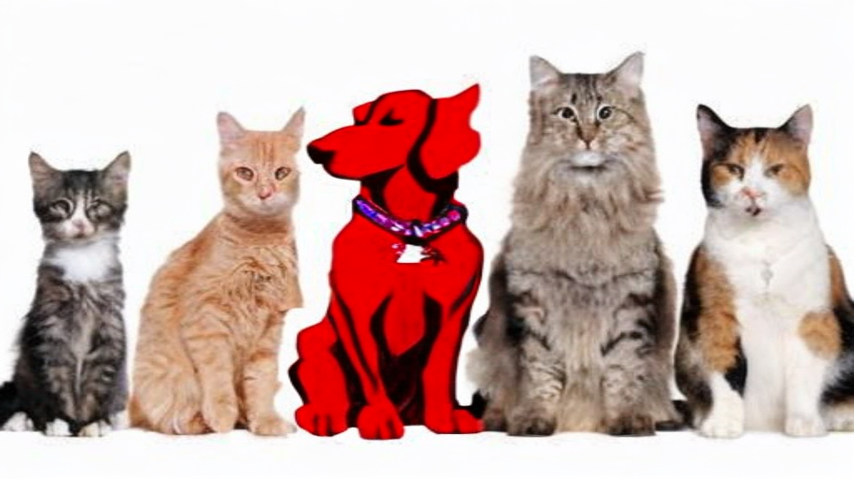

In [65]:
inpaint_mask("red dog", image_source, image_mask)

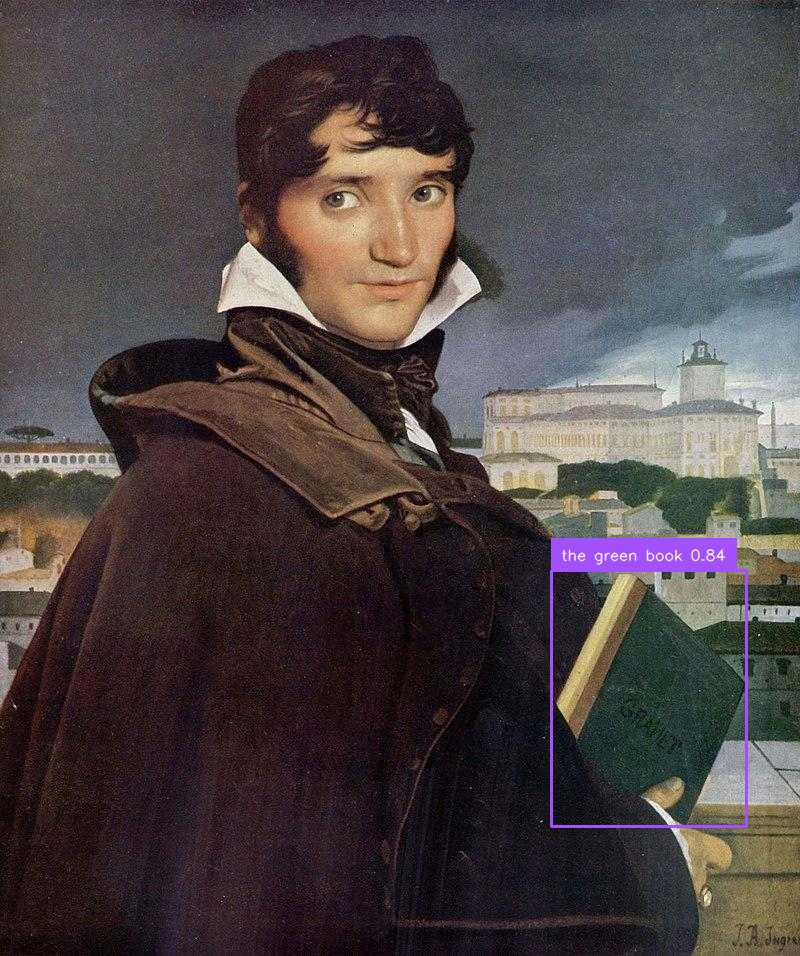

In [91]:
local_image_path = '/home/pcarragh/dev/webqa/val_images/30002003.jpeg'
image_source, annotated_frame, image_mask = get_frames_from_prompt(local_image_path, "the green book.")
Image.fromarray(annotated_frame)

  0%|          | 0/50 [00:00<?, ?it/s]

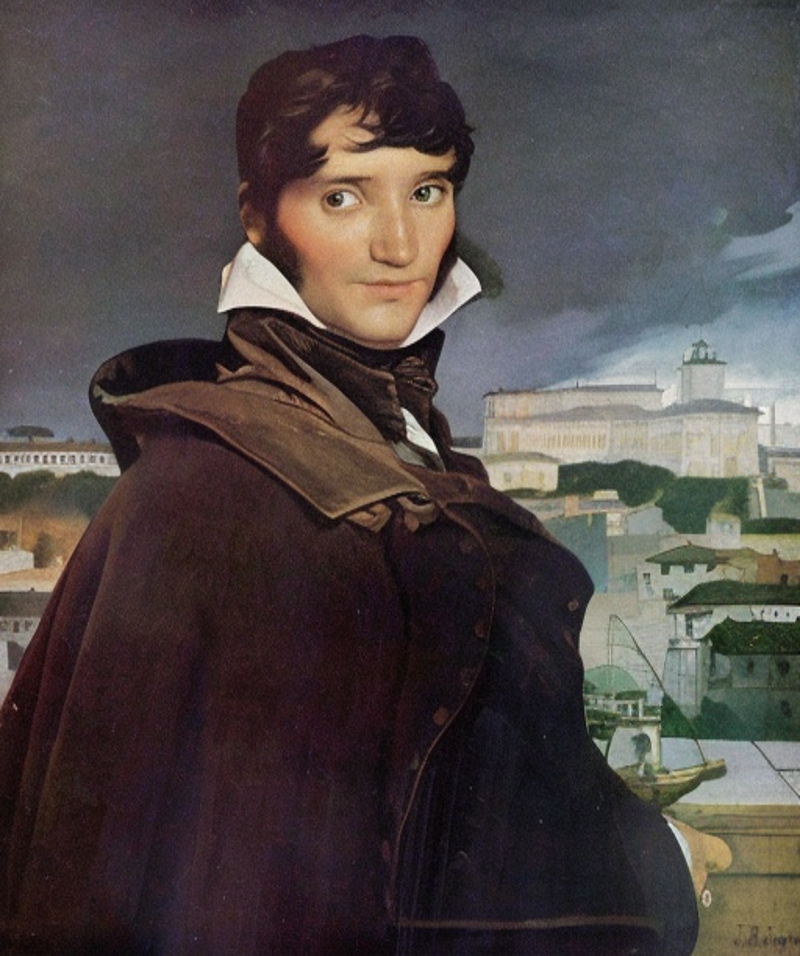

In [94]:
inpaint_mask("the sword", image_source, image_mask)